In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport new_IRMAD
# %aimport new_CCA

# %aimport sample_gen
# %aimport cca_compare
# %aimport irmad

import csv

import gdalio
import gdal

Populating the interactive namespace from numpy and matplotlib


In [2]:
def compare_side_by_side(img1,img2,pmin=None,pmax=None):
    s1 = np.linspace(-1,1,img1.shape[0])[:,np.newaxis] @ np.ones(img1.shape[1])[np.newaxis]
    s2 = np.ones(img1.shape[0])[:,np.newaxis] @ np.linspace(-1,1,img1.shape[1])[np.newaxis]
    disp_weights = 1/(1+np.exp((s1+s2)*50))[:,:,np.newaxis]
    img_total = (img1*disp_weights)+(img2*(1-disp_weights))
    
    if pmin is None or pmax is None:
        pmin = np.percentile(img_total,p,axis=(0,1))
        pmax = np.percentile(img_total,100-p,axis=(0,1))
        
    return normalize(img_total,pmin,pmax)

# Load aligned pairs of test samples

In [3]:
def normalize(data,pmin=None,pmax=None,clamp=True):
    if pmin is None:
        pmin = np.percentile(data,1,axis=(0,1))
    if pmax is None:
        pmax = np.percentile(data,95,axis=(0,1))
    ret = (data - pmin)/(pmax-pmin)
    if clamp:
        ret[ret<0] = 0
        ret[ret>1] = 1
    return ret

def visible(img):
    return ret[:,:,[3,2,1]]

with open("test_files_aligned.csv",'r') as f:
    reader = csv.reader(f.readlines())
    next(reader) # skip header
    test_pairs = [i for i in reader]
    print(len(test_pairs),'pairs loaded')
    
    
# Select specific test pair
f1, f2 = test_pairs[6]

59 pairs loaded


In [4]:
# load custom file pair
f1 = '/home/artef/Maps/dubai_2016_2018_pair_2016.tiff'
f2 = '/home/artef/Maps/dubai_2016_2018_pair_2018.tiff'

In [5]:
# read images
img1, img2 = gdalio.readAsArray(gdal.Open(f1)), gdalio.readAsArray(gdal.Open(f2))

In [6]:
img1 = img1[:,int(img1.shape[1]*0.5):,:]
img2 = img2[:,int(img2.shape[1]*0.5):,:]

In [7]:
# mask-out null elements
not_null_mask = (( (img1 == 0).sum(axis=2) == 0 ) & ( (img2 == 0).sum(axis=2) == 0 ))

# Specify percentilles for proper output normalization
p_min = np.percentile( np.concatenate( (img1[not_null_mask].reshape(-1,img1.shape[-1]),img2[not_null_mask].reshape(-1,img2.shape[-1])),axis=0 ), 1, axis=(0) )
p_max = np.percentile( np.concatenate( (img1[not_null_mask].reshape(-1,img1.shape[-1]),img2[not_null_mask].reshape(-1,img2.shape[-1])),axis=0 ), 99, axis=(0) )


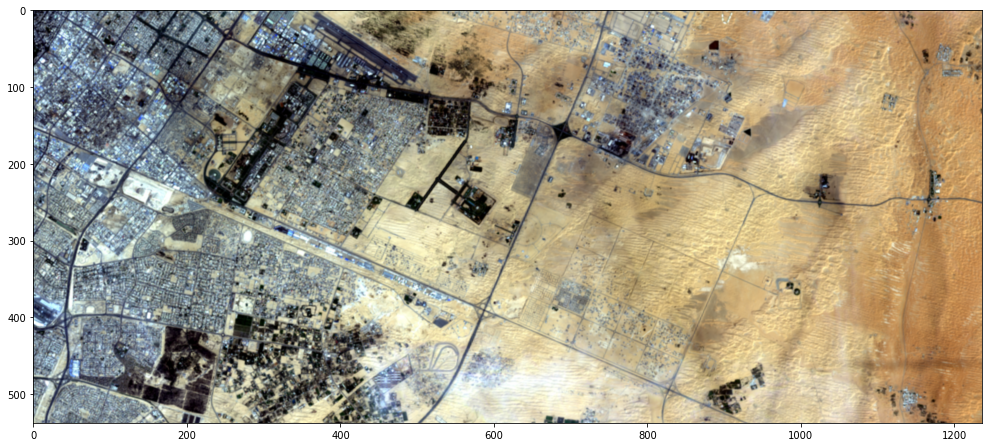

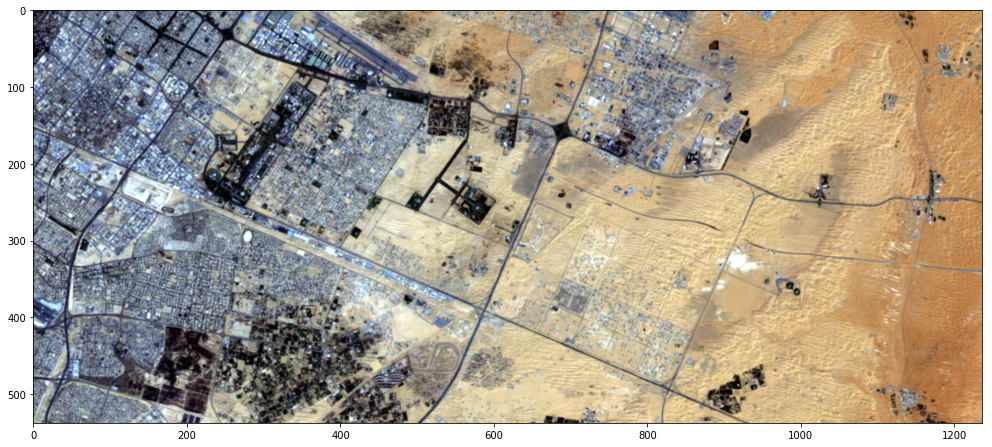

In [14]:
# output data
figsize(17,17)
imshow( normalize( img1, p_min, p_max )[:,:,[3,2,1]], interpolation='bicubic' );
show();
imshow( normalize( img2, p_min, p_max )[:,:,[3,2,1]], interpolation='bicubic' );

# Prepare data

# number of bands
k = img1.shape[2]

# data
X = img1[not_null_mask].reshape(-1,k)
Y = img2[not_null_mask].reshape(-1,k)

In [15]:
irmad = new_IRMAD.IRMAD(k)
change_vals = []

In [16]:
# Iterate irmad
for i in range(40):
    irmad.push_data(X,Y)
    ch_val = irmad.commit_iteration()
    if ch_val is not None:
        change_vals.append(ch_val)

    if len(change_vals) > 0:
        print('Iter {}: {}'.format(irmad.iteration_num,change_vals[-1]))

Iter 2: 0.16731312836067241
Iter 3: 0.07978371168946734
Iter 4: 0.0503939079321466
Iter 5: 0.03589780293523432
Iter 6: 0.035957584173317375
Iter 7: 0.04288799113786548
Iter 8: 0.06029753513914725
Iter 9: 0.05598669751136507
Iter 10: 0.03246757718907356
Iter 11: 0.019675005755294427
Iter 12: 0.013043304661865048
Iter 13: 0.00968736360785421
Iter 14: 0.009257425337892188
Iter 15: 0.008515837574277
Iter 16: 0.007871487194324794
Iter 17: 0.007316361115099298
Iter 18: 0.006833997346021938
Iter 19: 0.0064032978952760725
Iter 20: 0.005971265357849934
Iter 21: 0.005532806010944434
Iter 22: 0.005289084323249155
Iter 23: 0.0050122348802016286
Iter 24: 0.004683351109433394
Iter 25: 0.0043353875941803295
Iter 26: 0.003984249346779561
Iter 27: 0.003640736863373347
Iter 28: 0.003312748465999733
Iter 29: 0.003005514008775734
Iter 30: 0.0027218682779091745
Iter 31: 0.0024627402733387697
Iter 32: 0.002227705139572118
Iter 33: 0.0020155094475870945
Iter 34: 0.0018244493124152997
Iter 35: 0.0016526594532

In [129]:
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression

w_disp = np.zeros( (img1.shape[0],img1.shape[1]) )
w_disp[not_null_mask] = w

x_reg = img1[ w_disp.reshape((img1.shape[0],img1.shape[1]) ) > 0.97 ]
y_reg = img2[ w_disp.reshape((img1.shape[0],img1.shape[1]) ) > 0.97 ]
w_reg = w_disp[ w_disp>0.97 ]

band_index = 8

#odr_reg = fit_odr(y_reg[:,band_index][w_reg>0.97],x_reg[:,band_index][w_reg>0.97])

lin_reg = LinearRegression()
lin_reg.fit(y_reg[:,band_index,np.newaxis],x_reg[:,band_index],w_reg)

hub_reg = HuberRegressor()
hub_reg.fit(y_reg[:,band_index,np.newaxis],x_reg[:,band_index],w_reg)

figsize(6,4)
scatter( y_reg[:,band_index][w_reg>0.95], x_reg[:,band_index][w_reg>0.95], c='k', marker='x', alpha=0.1);
ylabel("x");
xlabel("y");
y_pred_space =  np.linspace(y_reg[:,band_index].min(),y_reg[:,band_index].max(),100) 
#plot( y_pred_space, predict_odr(odr_reg,y_pred_space),label="ODR");
plot( y_pred_space, lin_reg.predict(y_pred_space[:,np.newaxis]),label="OLS" )
plot( y_pred_space, hub_reg.predict(y_pred_space[:,np.newaxis]),label="HUB" )
legend();

ValueError: NumPy boolean array indexing assignment cannot assign 1329369 input values to the 664968 output values where the mask is true

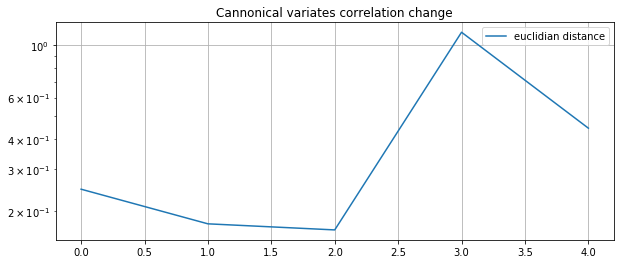

In [70]:
figsize(10,4);
title("Cannonical variates correlation change")
plot(change_vals,label="euclidian distance")
yscale("log")
grid();
legend();

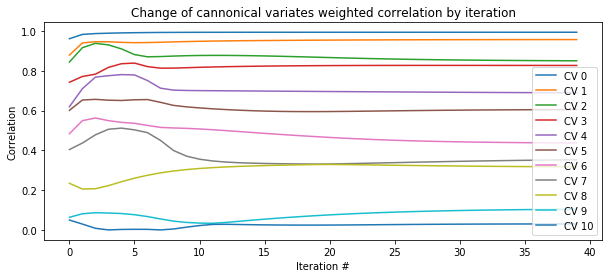

In [136]:
figsize(10,4)
for bn, cor in enumerate( np.array(irmad.cor_log).T ):
    plot(cor,label='CV {}'.format(bn))  
legend();
title("Change of cannonical variates weighted correlation by iteration")
xlabel("Iteration #")
ylabel("Correlation")
show();

# Output probability map

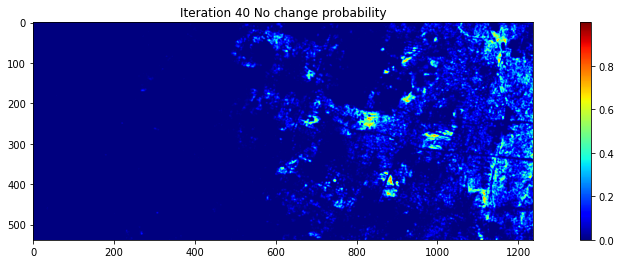

In [137]:
figsize(17,4);
w = irmad.calc_nochange_proba(X,Y);
w_true = np.ones(img1.shape[:-1])
w_true[not_null_mask] = w
imshow( w_true , cmap='jet', interpolation='bicubic');
title("Iteration {} No change probability".format(irmad.iteration_num))
colorbar();
show();

In [150]:
U,V = irmad.get_stats(img1.reshape(-1,11),img2.reshape(-1,11))

In [154]:
(U-V).T.reshape(img1.shape)

(538, 1236, 11)

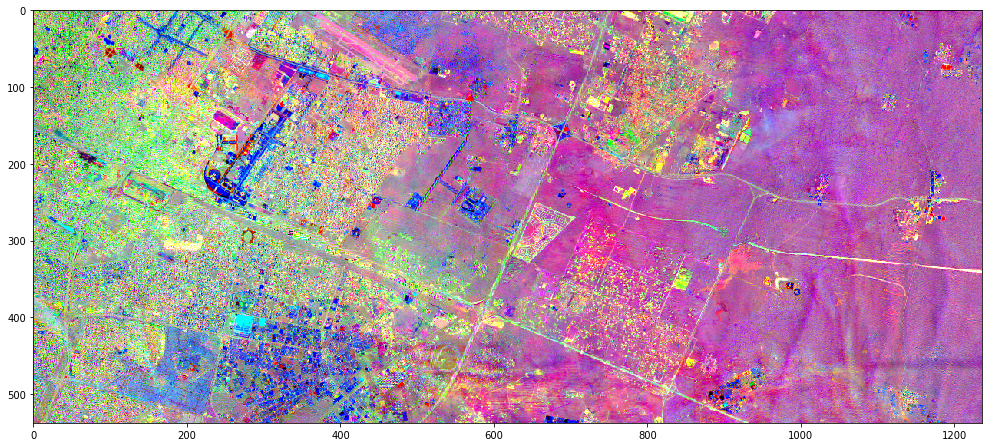

In [163]:
figsize(17,17)
imshow( normalize( (U-V).T.reshape(img1.shape) )[:,:,[0,1,2]] );

# Apply transformation

In [164]:
trans = irmad.calc_transformation(X,Y,fit_algo="OLS",weight_cutoff=0.95)

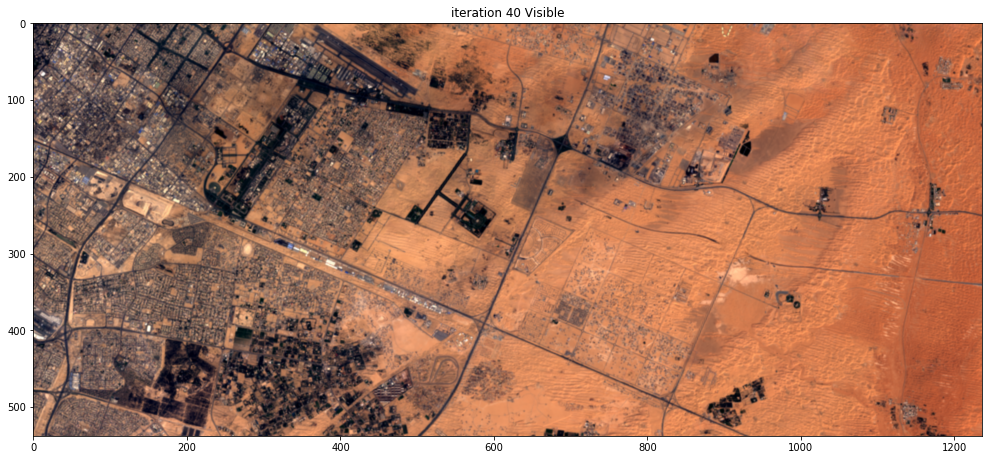

In [183]:
img2_res = irmad.apply_transformation(img1,img2,trans)
title("iteration {} Visible".format(irmad.iteration_num) );
figsize(17,17);
imshow( compare_side_by_side(img1,img2, p_min, p_max)[:,:,[3,2,1]], interpolation='bicubic');
show();

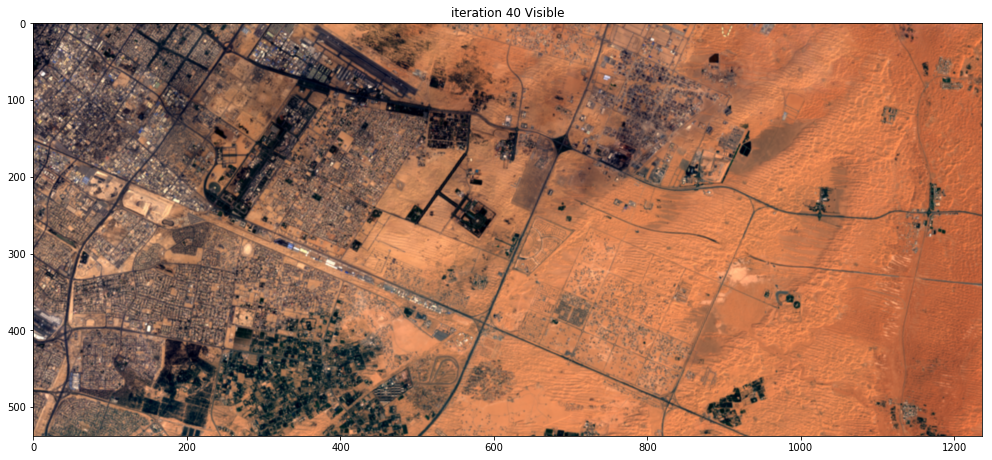

In [182]:
img2_res = irmad.apply_transformation(img1,img2,trans)
title("iteration {} Visible".format(irmad.iteration_num) );
figsize(17,17);
imshow( compare_side_by_side(img1,img2_res, p_min, p_max)[:,:,[3,2,1]], interpolation='bicubic');
show();

In [192]:
p_max = p_max[[1,2,3]].max()
p_min = p_min[[1,2,3]].min()